
=== Model: CRR ===
u = 1.2214, d = 0.8187, p = 0.6302


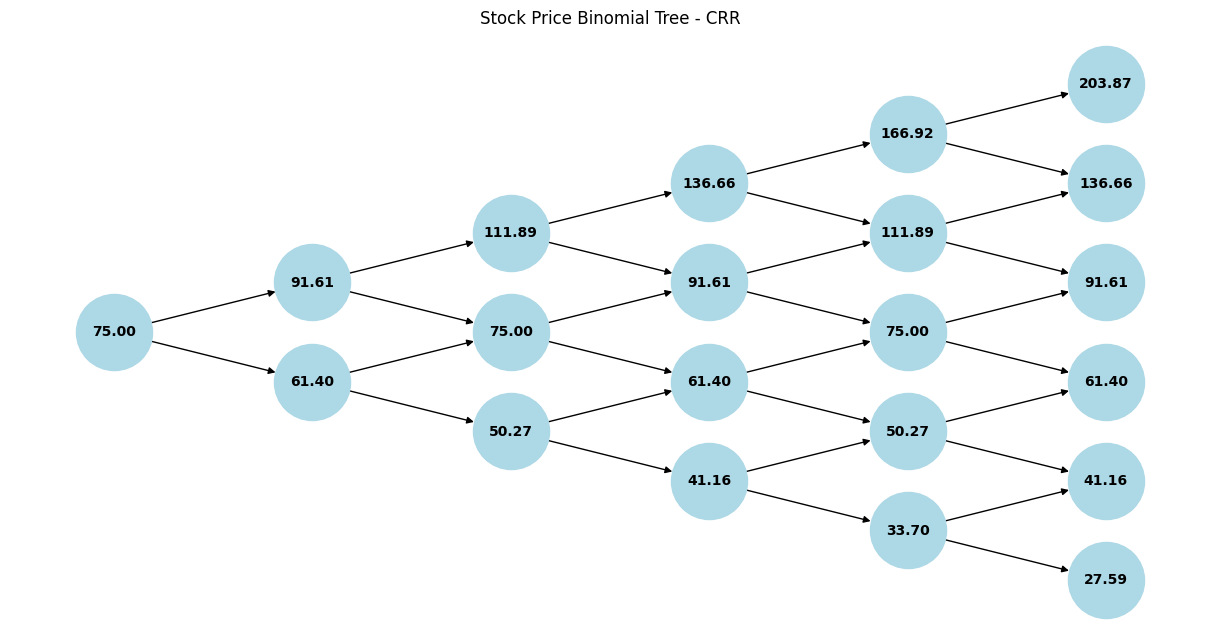


=== Model: Jarrow-Rudd ===
u = 1.2840, d = 0.8607, p = 0.5000


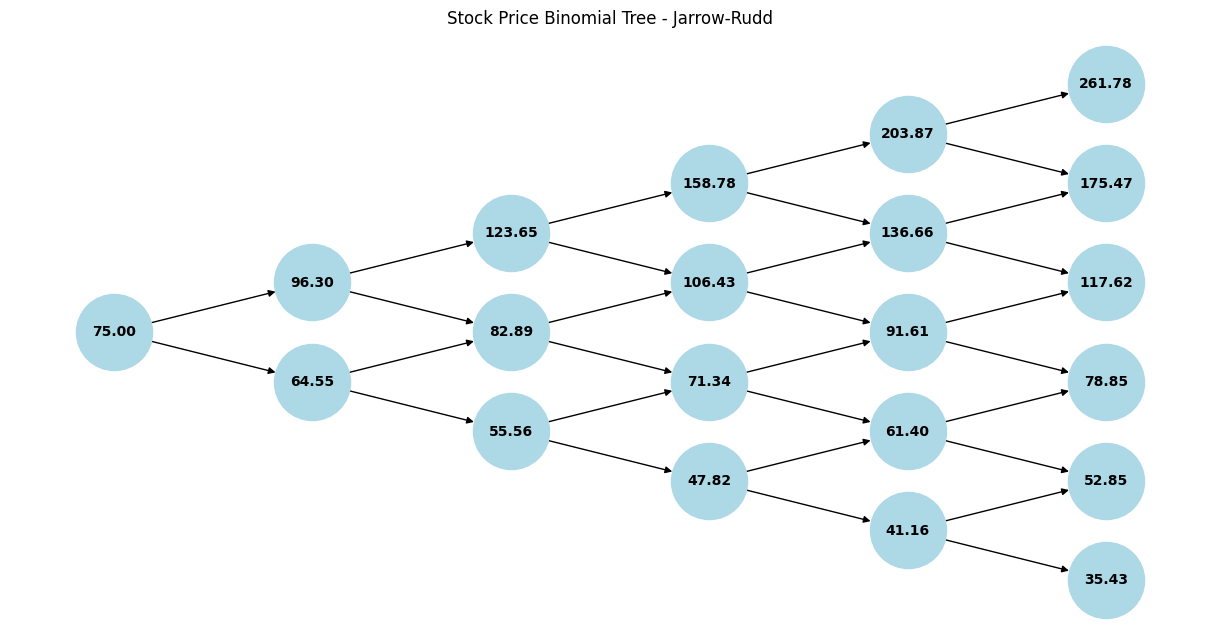


=== Model: Tian ===
u = 2.1881, d = 0.4902, p = 0.3430


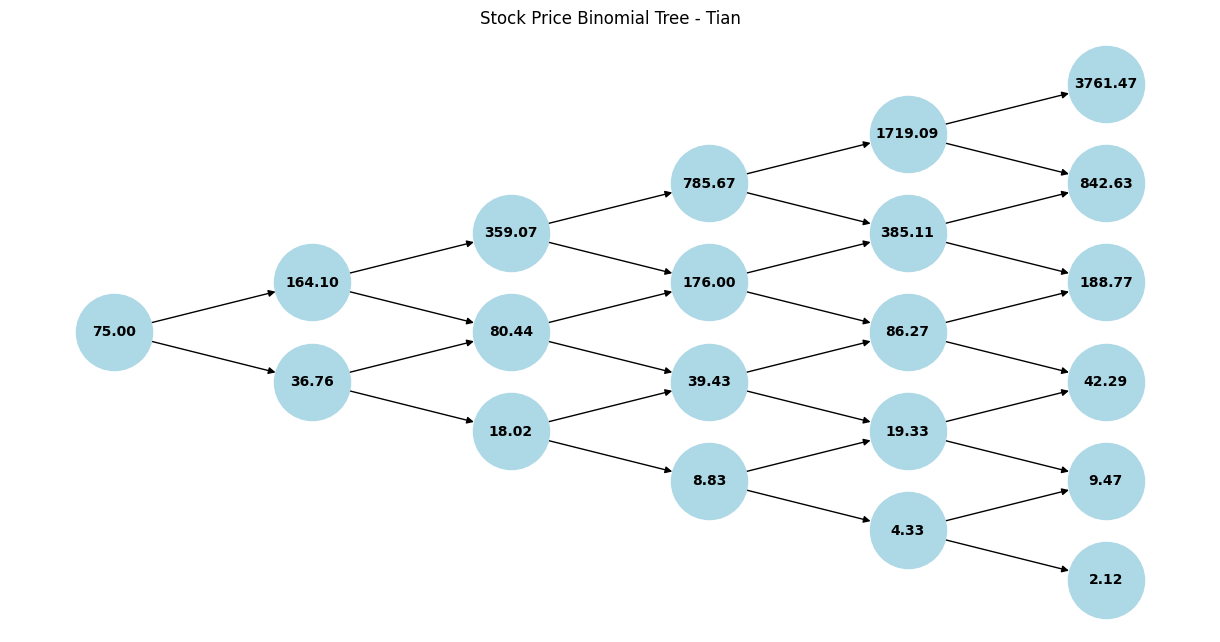


=== Model: CRR_Drift ===
u = 1.2214, d = 0.8187, p = 0.6302


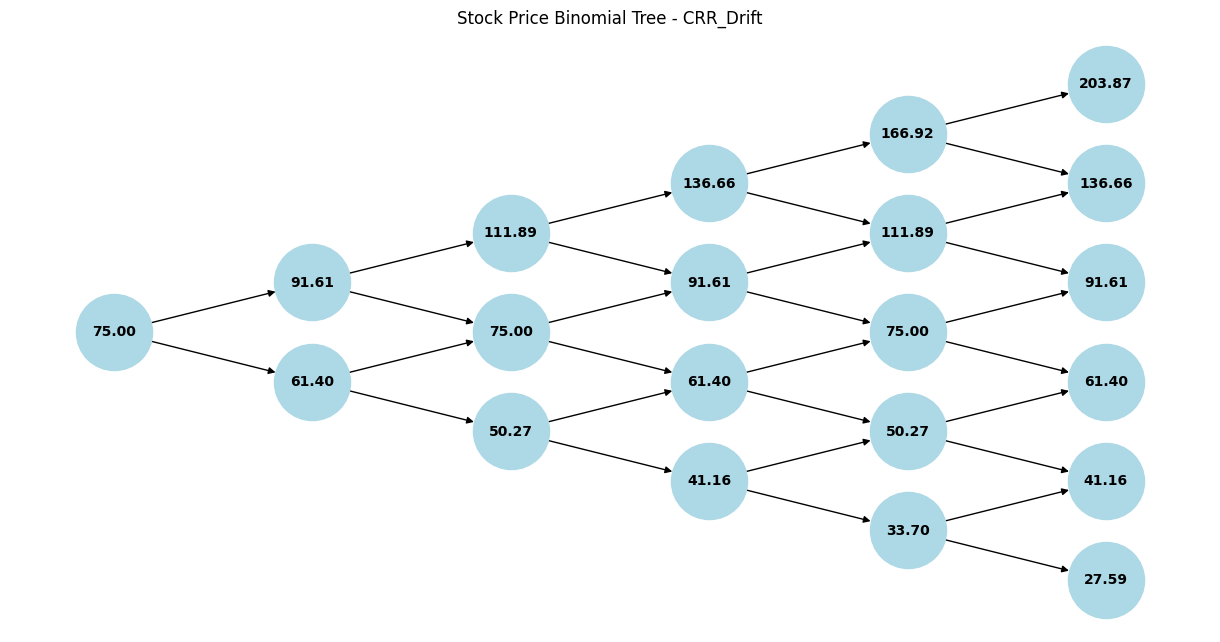


=== Model: Haahtela ===
u = 1.4140, d = 0.7072, p = 0.4868


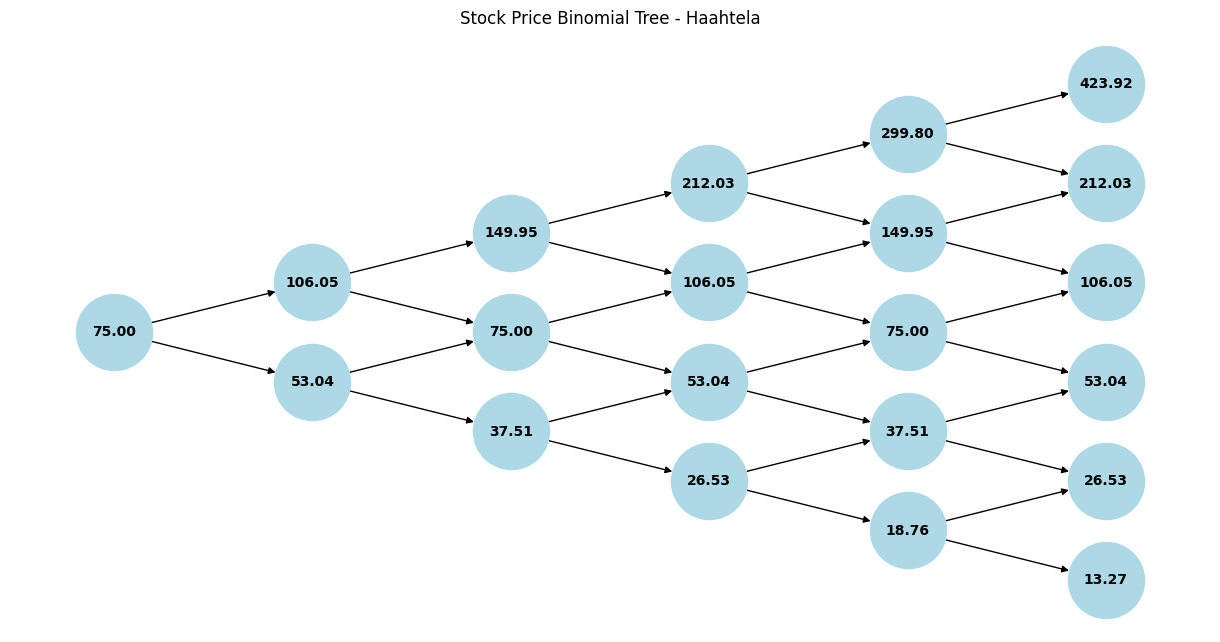

In [16]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import norm

# Function to calculate tree parameters (u, d, p) for different models
def calculate_tree_parameters(r, q, sigma, dt, model_type, drift=0):
    if model_type == 'CRR':
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp((r - q) * dt) - d) / (u - d)
    elif model_type == 'CRR_Drift':
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp((r - q + drift) * dt) - d) / (u - d)
    elif model_type == 'Jarrow-Rudd':
        u = np.exp((r - q - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt))
        d = np.exp((r - q - 0.5 * sigma ** 2) * dt - sigma * np.sqrt(dt))
        p = 0.5
    elif model_type == 'Tian':
        a = np.exp((r - q) * dt)
        b = np.exp(sigma * np.sqrt(dt))
        u = 0.5 * a * (b + 1 / b + np.sqrt((b - 1 / b) ** 2 + 4))
        d = a / u
        p = (a - d) / (u - d)
    elif model_type == 'Haahtela':
        b = r - q - 0.5 * sigma**2
        u = np.exp(sigma * np.sqrt(3 * dt))
        d = 1 / u
        p = (np.exp(b * dt) - d) / (u - d)       
    else:
        raise ValueError("Unknown model type provided.")
    
    return u, d, p


# Funzione per generare il plot dell'albero
def plot_binomial_tree(tree, title):
    steps = tree.shape[1] - 1
    G = nx.DiGraph()
    pos = {}
    labels = {}
    
    for i in range(steps + 1):
        for j in range(i + 1):
            node = f"{i},{j}"
            G.add_node(node)
            pos[node] = (i, j - (i / 2))  # Posizione simmetrica per allineare i nodi
            labels[node] = f"{tree[j, i]:.2f}"
            if i < steps:
                G.add_edge(node, f"{i+1},{j}")
                G.add_edge(node, f"{i+1},{j+1}")

    plt.figure(figsize=(12, 6))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="black")
    plt.title(title)
    plt.show()

# Funzione principale per creare e plottare gli alberi alternativi
def create_and_plot_trees(S0, F, T, r, sigma, q, coupon, conversion_ratio, steps, models):
    dt = T / steps
    stock_trees = {}
    bond_trees = {}
    
    for model in models:
        print(f"\n=== Model: {model} ===")
        
        # Calcola i parametri dell'albero per il modello specificato
        u, d, p = calculate_tree_parameters(r, q, sigma, dt, model)

        # Costruisce l'albero dei prezzi delle azioni
        StockPrice = np.zeros((steps + 1, steps + 1))
        for i in range(steps + 1):
            for j in range(i + 1):
                StockPrice[j, i] = S0 * (u ** j) * (d ** (i - j))
        
        # Stampa i parametri del modello
        print(f"u = {u:.4f}, d = {d:.4f}, p = {p:.4f}")
        
        # Visualizza l'albero dei prezzi delle azioni
        plot_binomial_tree(StockPrice, f"Stock Price Binomial Tree - {model}")

        # Salva i risultati per future analisi
        stock_trees[model] = StockPrice

    return stock_trees

# Parametri di input
S0 = 75           # Prezzo iniziale dell'azione
F = 100           # Valore nominale del bond
T = 5             # Tempo alla scadenza in anni
r = 0.07          # Tasso privo di rischio
sigma = 0.2       # Volatilità
q = 0             # Dividend yield
coupon = 6        # Pagamento cedolare annuo
conversion_ratio = 1  # Rapporto di conversione
steps = 5         # Numero di step nell'albero

# Definire i modelli da plottare
models = ['CRR', 'Jarrow-Rudd', 'Tian', 'CRR_Drift', 'Haahtela']

# Generare e plottare gli alberi
stock_trees = create_and_plot_trees(S0, F, T, r, sigma, q, coupon, conversion_ratio, steps, models)


**Convergence of Convertible Bond Price for Different Models**

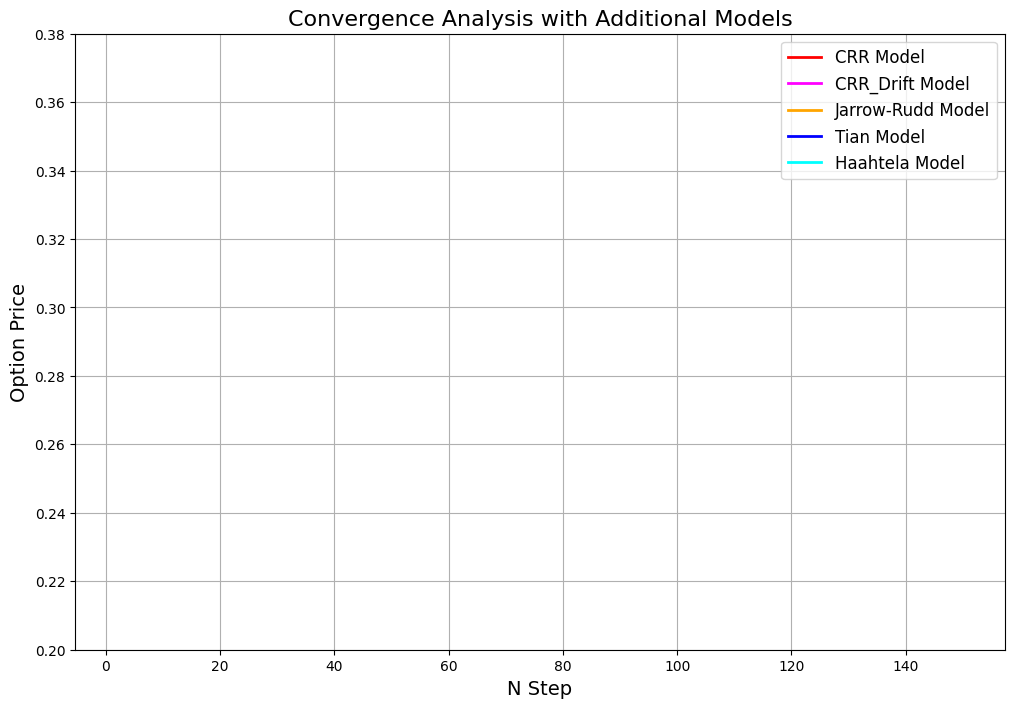

In [19]:
# Calculate option price using the specific binomial tree model
def calculate_option_price(S0, F, T, r, sigma, q, steps, model_type, drift=0):
    dt = T / steps
    u, d, p = calculate_tree_parameters(r, q, sigma, dt, model_type, drift)

    # Stock price tree construction
    StockPrice = np.zeros((steps + 1, steps + 1))
    for i in range(steps + 1):
        for j in range(i + 1):
            StockPrice[j, i] = S0 * (u ** j) * (d ** (i - j))

    # Option price tree
    OptionPrice = np.zeros((steps + 1, steps + 1))

    # Calculate option value at maturity (European Call Option)
    for i in range(steps + 1):
        OptionPrice[i, steps] = max(0, StockPrice[i, steps] - F)

    # Backward induction for option price
    for j in range(steps - 1, -1, -1):
        for i in range(j + 1):
            OptionPrice[i, j] = np.exp(-r * dt) * (p * OptionPrice[i + 1, j + 1] + (1 - p) * OptionPrice[i, j + 1])

    return OptionPrice[0, 0]

# Calculate convergence for different models and step sizes
def calculate_convergence(S0, F, T, r, sigma, q, max_steps, model_types, drift=0):
    step_range = range(2, max_steps + 1, 2)  # Use only even steps to match reference
    convergence_results = {model: [] for model in model_types}

    for steps in step_range:
        for model in model_types:
            price = calculate_option_price(S0, F, T, r, sigma, q, steps, model, drift)
            convergence_results[model].append(price)

    return step_range, convergence_results

# Plot the convergence results for each model
def plot_convergence(step_range, convergence_results):
    # Define custom colors for each model
    colors = {
        'CRR': 'red',
        'CRR_Drift': 'magenta',
        'Jarrow-Rudd': 'orange',
        'Tian': 'blue',
        'Haahtela': 'cyan'
    }
    
    plt.figure(figsize=(12, 8))
    
    for model, prices in convergence_results.items():
        color = colors.get(model, 'black')  # Default to black if the model is not in the color dictionary
        plt.plot(step_range, prices, label=f"{model} Model", color=color, linewidth=2)
    
    # Set axis labels, title, and legend
    plt.xlabel("N Step", fontsize=14)
    plt.ylabel("Option Price", fontsize=14)
    plt.ylim(0.20, 0.38)  # Set y-axis limits to match reference image
    plt.title("Convergence Analysis with Additional Models", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# Input parameters for convergence analysis
S0 = 100           # Initial stock price
F = 100            # Strike price
T = 1              # Time to maturity in years
r = 0.06           # Risk-free rate
sigma = 0.2        # Volatility
q = 0              # Dividend yield
max_steps = 150    # Maximum number of steps for convergence analysis

# Define the models to be tested, including Haahtela, LR_1, and LR_2
model_types = ['CRR', 'CRR_Drift', 'Jarrow-Rudd', 'Tian', 'Haahtela']

# Calculate convergence results
step_range, convergence_results = calculate_convergence(S0, F, T, r, sigma, q, max_steps, model_types)

# Plot the convergence results
plot_convergence(step_range, convergence_results)
